In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

import datetime as dt
import panel as pn # for interactive widgets
pn.extension()

In [2]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig, PlacefieldComputationParameters  # VideoOutputModeConfig, InteractivePlaceCellConfigs
from PhoPositionalData.analysis.interactive_placeCell_config import get_subsession_for_epoch, print_subsession_neuron_differences

In [3]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
from neuropy.core.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSession
from neuropy.core.epoch import NamedEpoch




## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m

# From pre-computed .mat files:
## 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'

# ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [4]:
# KDiba Old Format:
sess = DataSessionLoader.kdiba_old_format_session(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')
active_sess_config = sess.config
session_name = sess.name

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikeII.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
computing linear positions for all active epochs for session...
Saving updated position results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy...
2006-6-07_11-26-53.position.npy saved
done.

session.position linear positions computed!


In [5]:
sess.epochs.to_dataframe()

,start,stop,label,duration
0,0.000000,1739.153364,maze1,1739.153364
1,1739.153364,1932.420005,maze2,193.266641


In [14]:
# sess.position.print_debug_str()
sess.position.time # [603785.449121, ..., 605893.97363495]
df = sess.position.to_dataframe()
# df

In [16]:
## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
# active_epoch_name = 'maze1'
active_epoch_name = 'maze2'

active_epoch = NamedEpoch(
        name=active_epoch_name,
        start_end_times=sess.epochs[active_epoch_name]
    )

# active_epoch_name = 'maze'
# active_epoch = NamedEpoch(
#         name=active_epoch_name,
#         start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]]
#     )
# Constraining to epoch with times (start: 0.0, end: 1932.4200048116618)
# 20996/932598 total spikes spanning 40/64 units remain in subsession

active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right

## Get the config corresponding to this epoch/session settings:
# active_config = InteractivePlaceCellConfig(active_session_config=active_sess_config, active_epochs=active_epoch)
active_config = InteractivePlaceCellConfig(active_session_config=active_sess_config, active_epochs=active_epoch,
                        video_output_config=VideoOutputModeConfig(active_frame_range=np.arange(11070.0, 13970.0), video_output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name), active_is_video_output_mode=False),
                        plotting_config=PlottingConfig(output_subplots_shape=active_subplots_shape, output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name))) # '3|1    
## Looks like the only real outputs are: active_epoch_session_Neurons, active_epoch_pos
active_config.plotting_config.active_output_parent_dir.mkdir(parents=True, exist_ok=True) # makes the directory if it isn't already there

# Get the filtered and time-constrainted session and position data for this epoch:
# active_epoch_session_Neurons, active_epoch_pos, active_epoch_position_times = get_subsession_for_epoch(sess, active_epoch.name, active_epoch.start_end_times)

active_epoch_session = sess.time_slice(active_epoch.t_start, active_epoch.t_stop)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
active_epoch_session_Neurons, active_epoch_pos, active_epoch_position_times = active_epoch_session.neurons, active_epoch_session.position, active_epoch_session.position.time

Constraining to epoch with times (start: 1739.1533641185379, end: 1932.4200048116618)
2523/932598 total spikes spanning 40/64 units remain in subsession


Recomputing active_epoch_placefields...
Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze2\1D Placefields - maze2.pdf"...
done.
Recomputing active_epoch_placefields2D...
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze2\2D Occupancy - maze2.pdf"...
done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze2\2D Placefields - maze2.pdf"...
done.
good_placefield_neuronIDs: [ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57]; (19 good)


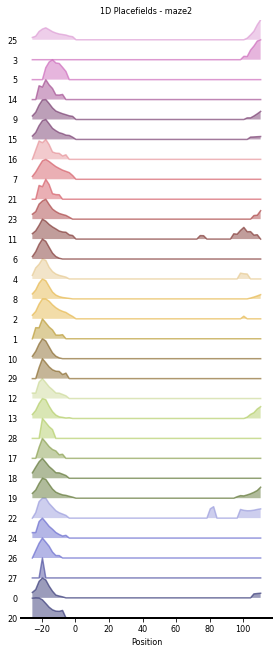

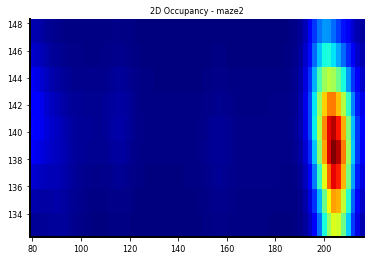

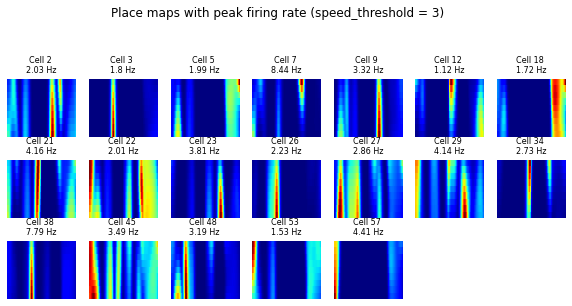

In [17]:
## Compute Placefields if needed:
from neuropy.analyses import Pf1D, Pf2D
from neuropy.plotting.spikes import get_neuron_colors

should_force_recompute_placefields = True
should_display_2D_plots = False
# Setup the placefield computation config
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=3, grid_bin=2, smooth=2)
# print_subsession_neuron_differences(sess.neurons, active_epoch_session_Neurons)

def perform_compute_placefields(active_epoch_session_Neurons, active_epoch_pos, active_epoch_placefields1D, active_epoch_placefields2D, active_config, should_force_recompute_placefields=True):
    """ 
    active_epoch_session_Neurons: 
    active_epoch_pos: 
    """
    active_epoch_name = active_config.active_epochs.name
    ## Linearized (1D) Position Placefields:
    if ((active_epoch_placefields1D is None) or should_force_recompute_placefields):
        print('Recomputing active_epoch_placefields...')
        # active_config
        active_epoch_placefields1D = Pf1D(neurons=active_epoch_session_Neurons, position=active_epoch_pos.linear_pos_obj,
                                          speed_thresh=active_config.computation_config.speed_thresh, grid_bin=active_config.computation_config.grid_bin, smooth=active_config.computation_config.smooth)
        ax_pf_1D = active_epoch_placefields1D.plot_ratemaps()
        active_pf_1D_identifier_string = '1D Placefields - {}'.format(active_epoch_name)
        plt.title(active_pf_1D_identifier_string)
        active_pf_1D_output_filename = '{}.pdf'.format(active_pf_1D_identifier_string)
        active_pf_1D_output_filepath = active_config.plotting_config.active_output_parent_dir.joinpath(active_pf_1D_output_filename)
        print('Saving 1D Placefield image out to "{}"...'.format(active_pf_1D_output_filepath))
        plt.savefig(active_pf_1D_output_filepath)
        print('done.')
    else:
        print('active_epoch_placefields1D already exists, reusing it')

    ## 2D Position Placemaps:
    if ((active_epoch_placefields2D is None) or should_force_recompute_placefields):
        print('Recomputing active_epoch_placefields2D...')
        active_epoch_placefields2D = Pf2D(neurons=active_epoch_session_Neurons, position=active_epoch_pos,
                                          speed_thresh=active_config.computation_config.speed_thresh, grid_bin=active_config.computation_config.grid_bin, smooth=active_config.computation_config.smooth)
        # active_epoch_placefields2D.plotMap(subplots=(1, 1),figsize=(10,10))
        # active_pf_2D_figures, active_pf_2D_gs = active_epoch_placefields2D.plotMap(subplots=(4, 4),figsize=(10, 10))
        # active_epoch_placefields2D.occupancy # (37, 38) = (len(active_epoch_placefields2D.ratemap.xbin_centers), len(active_epoch_placefields2D.ratemap.ybin_centers))
        active_pf_occupancy_2D_identifier_string = '2D Occupancy - {}'.format(active_epoch_name)
        occupancy_fig = plt.figure()
        occupancy_ax = occupancy_fig.gca()
        im = occupancy_ax.pcolorfast(
            active_epoch_placefields2D.ratemap.xbin_centers,
            active_epoch_placefields2D.ratemap.ybin_centers,
            np.rot90(np.fliplr(active_epoch_placefields2D.occupancy)) / np.max(active_epoch_placefields2D.occupancy),
            cmap="jet",
            vmin=0,
        )  # rot90(flipud... is necessary to match plotRaw configuration.
        plt.title(active_pf_occupancy_2D_identifier_string)
        if should_display_2D_plots:
            plt.show()
        # Save ocupancy figure out to disk:
        active_pf_occupancy_2D_output_filename = '{}.pdf'.format(active_pf_occupancy_2D_identifier_string)
        active_pf_occupancy_2D_output_filepath = active_config.plotting_config.active_output_parent_dir.joinpath(active_pf_occupancy_2D_output_filename)
        print('Saving 2D Placefield image out to "{}"...'.format(active_pf_occupancy_2D_output_filepath))
        occupancy_fig.savefig(active_pf_occupancy_2D_output_filepath)
        print('done.')
        ## 2D Tuning Curves Figure:
        active_pf_2D_figures, active_pf_2D_gs = active_epoch_placefields2D.plotMap(subplots=(7, 7),figsize=(10, 10))
        # active_epoch_placefields2D.plotRaw()
        active_pf_2D_identifier_string = '2D Placefields - {}'.format(active_epoch_name)
        # plt.title(active_pf_2D_identifier_string)
        active_pf_2D_output_filename = '{}.pdf'.format(active_pf_2D_identifier_string)
        active_pf_2D_output_filepath = active_config.plotting_config.active_output_parent_dir.joinpath(active_pf_2D_output_filename)
        print('Saving 2D Placefield image out to "{}"...'.format(active_pf_2D_output_filepath))
        for aFig in active_pf_2D_figures:
            aFig.savefig(active_pf_2D_output_filepath)
        print('done.')
    else:
        print('active_epoch_placefields already exists, reusing it')
    
    return active_epoch_placefields1D, active_epoch_placefields2D
    


try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step

try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step

active_epoch_placefields1D, active_epoch_placefields2D = perform_compute_placefields(active_epoch_session_Neurons, active_epoch_pos, active_epoch_placefields1D, active_epoch_placefields2D, active_config, should_force_recompute_placefields=True)
active_epoch_placefields = active_epoch_placefields2D
# Get the cell IDs that have a good place field mapping:
good_placefield_neuronIDs = np.array(active_epoch_placefields.ratemap.neuron_ids) # in order of ascending ID
print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)))

In [20]:
# pf_ax, pf_sort_ind, pf_colors = active_epoch_placefields.plot_ratemaps()
# from neuropy.utils import mathutil
# curr_tuning_curves = mathutil.min_max_scaler(active_epoch_placefields.ratemap.tuning_curves) # 37x25x27 ndarray
# curr_tuning_curves = active_epoch_placefields.ratemap.tuning_curves
curr_tuning_curves = active_epoch_placefields.ratemap.normalized_tuning_curves
# sort_ind = np.argsort(np.argmax(curr_tuning_curves, axis=1))
# ind = np.unravel_index(np.argsort(curr_tuning_curves, axis=None), curr_tuning_curves.shape)
num_curr_tuning_curves = len(curr_tuning_curves)
pf_sort_ind = np.arange(num_curr_tuning_curves)
pf_colors = get_neuron_colors(pf_sort_ind)
pf_sort_ind = np.array([int(pf_sort_ind[i]) for i in np.arange(len(pf_sort_ind))]) # convert to integer scalar array
pf_sorted_good_placefield_neuronIDs = good_placefield_neuronIDs[pf_sort_ind]
reverse_color_sort_indices = np.argsort(pf_sort_ind)
pf_colors = pf_colors[:, reverse_color_sort_indices] # pf_colors shape is still (4, 31)
active_epoch_session_Neurons = active_epoch_session_Neurons.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only, and this fetch also ensures they're returned in the sorted order


## Outputs: active_epoch_session_Neurons, pf_colors

# Unpacking final values into separate variables:
# Spike variables:
num_cells = active_epoch_session_Neurons.n_neurons
spike_list = active_epoch_session_Neurons.spiketrains
cell_ids = active_epoch_session_Neurons.neuron_ids
flattened_spikes = active_epoch_session_Neurons.get_flattened_spikes() # get_flattened_spikes(..) returns a FlattenedSpiketrains object
# Position variables: t, x, y
t = active_epoch_pos.time
x = active_epoch_pos.x
y = active_epoch_pos.y
linear_pos = active_epoch_pos.linear_pos
# speeds = active_epoch_pos.speed # note this has 1 less element than active_epoch_pos.x
# Determine the x and y positions each spike occured for each cell
spike_positions_list = build_spike_positions_list(spike_list, t, x, y)
reverse_cellID_idx_lookup_map = build_cellID_reverse_lookup_map(cell_ids)
print('num_cells: {}'.format(num_cells))
print('cell_ids: {}'.format(cell_ids)) # cell_ids is now a regular python list with 57 elements

active_cells_colormap = pf_colors.T # Make the colormap from the listed colors
active_cells_listed_colormap = ListedColormap(active_cells_colormap)

# Gets the flattened spikes, sorted in ascending timestamp for all cells.
num_flattened_spikes = np.size(flattened_spikes.flattened_spike_times)
print('num_flattened_spikes: {}'.format(num_flattened_spikes))
# Build the Active UnitIDs
flattened_spike_active_unitIdentities = np.array([int(reverse_cellID_idx_lookup_map[original_cellID]) for original_cellID in flattened_spikes.flattened_spike_identities]) # since flattened_spikes.flattened_spike_identities is already sorted, don't double sort
## Build the flattened spike positions list
flattened_spike_positions_list = np.concatenate(tuple(spike_positions_list), axis=1) # needs tuple(...) to conver the list into a tuple, which is the format it expects
flattened_spike_positions_list = flattened_spike_positions_list[:, flattened_spikes.flattened_sort_indicies] # ensure the positions are ordered the same as the other flattened items so they line up
print('flattened_spike_positions_list: {}'.format(np.shape(flattened_spike_positions_list)))

num_cells: 19
cell_ids: [ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57]
num_flattened_spikes: 2190
flattened_spike_positions_list: (2, 2190)


C:\Users\Pho\repos\NeuroPy\neuropy\utils\mathutil.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.min(x, axis=axis, keepdims=True)) / np.ptp(


In [21]:
## ICA and PCA Analysis
should_show_2D_ICA_plots = False
from PhoPositionalData.analysis.neuronal_dimensionality_reduction import runAnalysis_PCAandICA
active_session_ensembles, template, zsc_template, pca_data = runAnalysis_PCAandICA(active_epoch_session_Neurons, bin_size=0.250, frate_thresh=0.1, should_plot=should_show_2D_ICA_plots, active_cells_colormap=active_cells_colormap)

Based on frate_thresh, excluded neuron_ids: [26]


In [22]:
# have active_epoch_position_times: the actual times each position sample occured in seconds, active_epoch_relative_position_times: the same as active_epoch_position_times but starting at zero
# describe the movement

from PhoPositionalData.plotting.visualization_window import VisualizationWindow # Used to build "Windows" into the data points such as the window defining the fixed time period preceeding the current time where spikes had recently fired, etc.

# Split the position data into equal sized chunks to be displayed at a single time. These will look like portions of the trajectory and be used to animate. # Chunk the data to create the animation.
curr_plot_update_step = 1 # Update every frame
curr_plot_update_frequency = curr_plot_update_step * active_epoch_pos.sampling_rate # number of updates per second (Hz)
num_time_points = active_epoch_pos.n_frames / curr_plot_update_step
print('active_epoch_pos.sampling_rate (Hz): {}'.format(active_epoch_pos.sampling_rate))

# curr_window_duration = 2.5 # in seconds
# curr_view_window_length_samples = int(np.floor(curr_window_duration * active_epoch_pos.sampling_rate)) # number of samples the window should last
# recent_spikes_window = VisualizationWindow(duration_seconds=curr_window_duration, duration_num_frames=curr_view_window_length_samples)

# curr_recently_window_duration = 0.5 # in seconds
# curr_view_window_length_samples = int(np.floor(curr_window_duration * active_epoch_pos.sampling_rate)) # number of samples the window should last

## Simplified with just two windows:
longer_spikes_window = VisualizationWindow(duration_seconds=1024.0, sampling_rate=active_epoch_pos.sampling_rate) # have it start clearing spikes more than 30 seconds old
curr_view_window_length_samples = longer_spikes_window.duration_num_frames # number of samples the window should last
print('longer_spikes_window - curr_view_window_length_samples - {}'.format(curr_view_window_length_samples))

recent_spikes_window = VisualizationWindow(duration_seconds=1.0, sampling_rate=active_epoch_pos.sampling_rate)
curr_view_window_length_samples = recent_spikes_window.duration_num_frames # number of samples the window should last
print('recent_spikes_window - curr_view_window_length_samples - {}'.format(curr_view_window_length_samples))

## Build the sliding windows:
from numpy.lib.stride_tricks import sliding_window_view
# build a sliding window to be able to retreive the correct flattened indicies for any given timestep
active_epoch_position_linear_indicies = np.arange(np.size(active_epoch_position_times))
pre_computed_window_sample_indicies = recent_spikes_window.build_sliding_windows(active_epoch_position_linear_indicies)
# print('pre_computed_window_sample_indicies: {}\n shape: {}'.format(pre_computed_window_sample_indicies, np.shape(pre_computed_window_sample_indicies)))

## New Pre Computed Indicies Way:
z_fixed = np.full((recent_spikes_window.duration_num_frames,), 1.1)

active_epoch_pos.sampling_rate (Hz): 29.96976599553983
longer_spikes_window - curr_view_window_length_samples - 30689
recent_spikes_window - curr_view_window_length_samples - 29


## Main Spike/Placemap plotting:

In [ ]:
from PhoPositionalData.plotting.gui import customize_default_pyvista_theme, print_controls_helper_text
customize_default_pyvista_theme() # Sets the default theme values to those specified in my imported file
# This defines the position of the vertical/horizontal splitting, in this case 40% of the vertical/horizontal dimension of the window
# pv.global_theme.multi_rendering_splitting_position = 0.40
pv.global_theme.multi_rendering_splitting_position = 0.80

from PhoPositionalData.plotting.camera_manipulation import * # apply_camera_view, apply_close_perspective_camera_view, apply_close_overhead_zoomed_camera_view
from PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_data, build_flat_map_plot_data, perform_plot_flat_arena, build_spike_spawn_effect_light_actor, spike_geom_circle, spike_geom_box, spike_geom_cone, animal_location_circle, animal_location_trail_circle
# from PhoPositionalData.plotting.spikeAndPositions import InteractiveSliderWrapper # for wrapping the slider

num_time_points = active_epoch_pos.n_frames / curr_plot_update_step
# print('num_time_points: {}\n'.format(num_time_points))

## Opacity Helpers:
last_only_opacity_values = np.zeros([curr_view_window_length_samples,])
last_only_opacity_values[-1] = 1.0
# gradually_fading_opacity_values = np.arange(curr_view_window_length_samples)
gradually_fading_opacity_values = np.linspace(0.0, 1.0, curr_view_window_length_samples)
long_gradually_fading_opacity_values = np.linspace(0.0, 1.0, longer_spikes_window.duration_num_frames)
sharply_fading_opacity_values = np.linspace(0.0, 0.6, curr_view_window_length_samples)
# sharply_fading_opacity_values[-1] = 0.1 # last element (corresponding to current position) is set to 1.0

# active_trail_opacity_values = last_only_opacity_values.copy()
# active_trail_opacity_values = gradually_fading_opacity_values.copy()
active_trail_opacity_values = sharply_fading_opacity_values.copy()
# print('active_trail_opacity_values: {}\n'.format(np.shape(active_trail_opacity_values)))
# active_trail_size_values = np.full([curr_view_window_length_samples,], 0.6) # all have a scale of 0.6
active_trail_size_values = np.linspace(0.2, 0.6, curr_view_window_length_samples) # fade from a scale of 0.2 to 0.6
# active_trail_size_values[-1] = 6.0 # except for the end (current) point, which has a scale of 1.0
# active_trail_size_values = sharply_fading_opacity_values.copy()

# Plot Placemaps on 3D Plot

In [ ]:
from PhoPositionalData.plotting.spikeAndPositions import plot_placefields2D, update_plotVisiblePlacefields2D, build_custom_placefield_maps_lookup_table
from PhoPositionalData.plotting.gui import SetVisibilityCallback, MutuallyExclusiveRadioButtonGroup, add_placemap_toggle_checkboxes, add_placemap_toggle_mutually_exclusive_checkboxes

from PhoPositionalData.plotting.gui import CallbackSequence, SetUICheckboxValueCallback, OnUICheckboxChangedCallback
# from PhoGui import vtk_ui
# from PhoGui.vtk_ui.manager import get_manager, manager_exists, delete_manager
from pyvista import _vtk
# import vtk
# noinspection PyUnresolvedReferences
import vtkmodules.vtkInteractionStyle
# noinspection PyUnresolvedReferences
import vtkmodules.vtkRenderingOpenGL2
from vtkmodules.vtkCommonColor import vtkNamedColors
from vtkmodules.vtkCommonCore import vtkLookupTable
from vtkmodules.vtkFiltersCore import vtkElevationFilter
from vtkmodules.vtkFiltersModeling import vtkBandedPolyDataContourFilter
from vtkmodules.vtkFiltersSources import vtkConeSource
from vtkmodules.vtkRenderingCore import (
    vtkActor,
    vtkPolyDataMapper,
    vtkRenderWindow,
    vtkRenderWindowInteractor,
    vtkRenderer
)
nc = vtkNamedColors()

from pyvista.plotting.tools import parse_color, FONTS

from PhoGui.PhoCustomVtkWidgets import PhoWidgetHelper
from PhoGui.PhoCustomVtkWidgets import MultilineTextConsoleWidget


## Customizing Placemaps:
def temp_update_plotted_placefields2D(pTuningCurves, active_placefields, pf_colors, zScalingFactor=10.0):
    # Plots 2D Placefields in a 3D PyVista plot
    # curr_tuning_curves = active_placefields.ratemap.tuning_curves
    curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
    # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
    curr_tuning_curves = curr_tuning_curves * zScalingFactor
    num_curr_tuning_curves = len(curr_tuning_curves)
    # Get the cell IDs that have a good place field mapping:
    good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
    tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)
    # Loop through the tuning curves and plot them:
    # print('num_curr_tuning_curves: {}'.format(num_curr_tuning_curves))
    tuningCurvePlotActors = []
    for i in np.arange(num_curr_tuning_curves):
        curr_active_neuron_ID = good_placefield_neuronIDs[i]
        curr_active_neuron_color = pf_colors[:, i]
        curr_active_neuron_pf_identifier = 'pf[{}]'.format(curr_active_neuron_ID)
        curr_active_neuron_tuning_Curve = np.squeeze(curr_tuning_curves[i,:,:]).T.copy() # A single tuning curve
        # point_cloud_fixedSegements_positionTrail = np.column_stack((x[active_window_sample_indicies], y[active_window_sample_indicies], z_fixed))
        # pdata_positionTrail = pv.PolyData(point_cloud_fixedSegements_positionTrail.copy()) # a mesh
        
        # Get the points as a 2D NumPy array (N by 3)
        # curr_active_neuron_tuning_Curve_points = np.c_[tuningCurvePlot_x.reshape(-1), tuningCurvePlot_y.reshape(-1), curr_active_neuron_tuning_Curve.reshape(-1)]
        # curr_active_neuron_tuning_Curve_cloud = pv.wrap(curr_active_neuron_tuning_Curve_points)
        # simply pass the numpy points to the PolyData constructor
        # poly = pv.PolyData(curr_active_neuron_tuning_Curve_points)
        # poly.plot(point_size=15)

        # pdata_currActiveNeuronTuningCurve.points = curr_active_neuron_tuning_Curve.ravel(order="F") # Set the coordinates from the numpy array
        # pdata_currActiveNeuronTuningCurve.dimensions = [np.shape(curr_active_neuron_tuning_Curve)[0], np.shape(curr_active_neuron_tuning_Curve)[1], 1] # set the dimensions
        
        # curr_active_neuron_tuning_Curve[curr_active_neuron_tuning_Curve < 0.1] = np.nan
        pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
        pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
        # contours_currActiveNeuronTuningCurve = pdata_currActiveNeuronTuningCurve.contour()
        # pdata_currActiveNeuronTuningCurve.plot(show_edges=True, show_grid=True, cpos='xy', scalars=curr_active_neuron_tuning_Curve.T)        
        # actor_currActiveNeuronTuningCurve = pTuningCurves.add_mesh(pdata_currActiveNeuronTuningCurve, label=curr_active_neuron_pf_identifier, name=curr_active_neuron_pf_identifier, show_edges=False, nan_opacity=0.0, color=curr_active_neuron_color, use_transparency=True)
        # surf = poly.delaunay_2d()
        # pTuningCurves.add_mesh(surf, label=curr_active_neuron_pf_identifier, name=curr_active_neuron_pf_identifier, show_edges=False, nan_opacity=0.0, color=curr_active_neuron_color, opacity=0.9, use_transparency=False, smooth_shading=True)
        pdata_currActiveNeuronTuningCurve_plotActor = pTuningCurves.add_mesh(pdata_currActiveNeuronTuningCurve, label=curr_active_neuron_pf_identifier, name=curr_active_neuron_pf_identifier, 
                                                                            #  show_edges=True, edge_color=curr_active_neuron_color, line_width=3.0, render_lines_as_tubes=True, 
                                                                            #  nan_opacity=0.0, color=curr_active_neuron_color, opacity=0.9, use_transparency=False, smooth_shading=True, render=False)
                                                                            # show_edges=False, nan_opacity=0.0, color=curr_active_neuron_color, opacity=0.3, use_transparency=False, smooth_shading=True, render=False)
                                                                            show_edges=False, nan_opacity=0.0, color=curr_active_neuron_color, scalars='Elevation', opacity='sigmoid', use_transparency=False, smooth_shading=True, show_scalar_bar=False, render=False) 
        # pdata_currActiveNeuronTuningCurve_plotActor.GetProperty().SetColor(nc.GetColor3d('Salmon'))
         ## Fixes the problem of the scalars determining the object's color when I don't want them to:
        # pdata_currActiveNeuronTuningCurve_plotActor.GetMapper().ScalarVisibilityOff() # Scalars not used to color objects        
        lut = build_custom_placefield_maps_lookup_table(curr_active_neuron_color.copy(), 3, [0.0, 0.6, 1.0])
        # lut = build_custom_placefield_maps_lookup_table(curr_active_neuron_color.copy(), 5, [0.0, 0.0, 0.3, 0.5, 0.9])
        lut.SetTableRange(pdata_currActiveNeuronTuningCurve_plotActor.GetMapper().GetScalarRange())
        lut.Build()
        pdata_currActiveNeuronTuningCurve_plotActor.GetMapper().SetLookupTable(lut)
        pdata_currActiveNeuronTuningCurve_plotActor.GetMapper().SetScalarModeToUsePointData()
        # pTuningCurves.add_mesh(contours_currActiveNeuronTuningCurve, color=curr_active_neuron_color, line_width=1, name='{}_contours'.format(curr_active_neuron_pf_identifier), render=False)
        tuningCurvePlotActors.append(pdata_currActiveNeuronTuningCurve_plotActor)
        
    pTuningCurves.show_grid()
    pTuningCurves.add_axes(line_width=5, labels_off=False)
    pTuningCurves.enable_depth_peeling(number_of_peels=num_curr_tuning_curves)
    pTuningCurves.enable_3_lights()
    
    return pTuningCurves, tuningCurvePlotActors

## Build the new BackgroundPlotter:
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
if (pActiveTuningCurvesPlotter is not None):
    if isinstance(pActiveTuningCurvesPlotter, pvqt.BackgroundPlotter):
        if pActiveTuningCurvesPlotter.app_window.isHidden():
            print('No open BackgroundPlotter')
            pActiveTuningCurvesPlotter.close() # Close it to start over fresh
            pActiveTuningCurvesPlotter = None
            needs_create_new_backgroundPlotter = True
        else:
            print('BackgroundPlotter already open, reusing it.. NOT Forcing creation of a new one!')
            # p.app_window.window().show()
            # p.clear()
            # needs_create_new_backgroundPlotter = False                
            pActiveTuningCurvesPlotter.close() # Close it to start over fresh
            pActiveTuningCurvesPlotter = None
            needs_create_new_backgroundPlotter = True

    else:
        print('No open BackgroundPlotter, p is a Plotter object')
        pActiveTuningCurvesPlotter.close()
        pActiveTuningCurvesPlotter = None
        needs_create_new_backgroundPlotter = True
else:
    print('No extant BackgroundPlotter')
    needs_create_new_backgroundPlotter = True
if needs_create_new_backgroundPlotter:
    print('Creating a new BackgroundPlotter')
    pActiveTuningCurvesPlotter = pvqt.BackgroundPlotter(window_size=(1920, 1080), shape=(1,1), off_screen=False) # Use just like you would a pv.Plotter() instance
    print('done.')


# Plot the flat arena
perform_plot_flat_arena(pActiveTuningCurvesPlotter, x, y, bShowSequenceTraversalGradient=False)
pActiveTuningCurvesPlotter, tuningCurvePlotActors, tuningCurvePlotLegendActor = plot_placefields2D(pActiveTuningCurvesPlotter, active_epoch_placefields, pf_colors, zScalingFactor=10.0) 
# pActiveTuningCurvesPlotter, tuningCurvePlotActors = temp_update_plotted_placefields2D(pActiveTuningCurvesPlotter, active_epoch_placefields, pf_colors, zScalingFactor=10.0)

# Adds a multi-line debug console to the GUI for output logging:
debug_console_widget = MultilineTextConsoleWidget(pActiveTuningCurvesPlotter)
debug_console_widget.add_line_to_buffer('test log')
# debug_console_widget.add_line_to_buffer('test log 2')


# for i, an_extant_tuningCurvePlot_actor in enumerate(tuningCurvePlotActors):
#     print(an_extant_tuningCurvePlot_actor)
#     an_extant_tuningCurvePlot_actor
#     an_extant_tuningCurvePlot_actor.opacity='sigmoid'

## Add placemap toggle checkboxes GUI:
# for i, an_extant_checkbox_widget_actor in enumerate(checkboxWidgetActors):
#     # print(an_extant_checkbox_widget_actor.GetRepresentation().GetBalloon()) # vtkBalloonRepresentation
    
#     # print(an_extant_checkbox_widget_actor.GetRepresentation().GetBalloon().GetImageProperty()) # vtkProperty2D 
#     print(an_extant_checkbox_widget_actor.GetRepresentation().GetBalloon().BalloonImage) # vtkProperty2D 
    
#     # print(an_extant_checkbox_widget_actor.GetRepresentation()) # vtkTexturedButtonRepresentation2D 
#     # print(an_extant_checkbox_widget_actor.GetRepresentation().GetBounds()) # RETURNS NONE
#     # print(an_extant_checkbox_widget_actor.GetRepresentation().GetProperty()) # vtkProperty2D 
#     # print(an_extant_checkbox_widget_actor.GetRepresentation().GetActors()) # vtkProperty2D 
#     # print(an_extant_checkbox_widget_actor.GetInteractor()) # vtkGenericRenderWindowInteractor     

 
def temp_add_placemap_toggle_mutually_exclusive_checkboxes(p, placemap_actors, colors, active_element_idx=0, widget_size=20, widget_start_pos=12, widget_border_size=3, require_active_selection=False, is_debug=False):
    # """ Adds a list of toggle checkboxes to turn on and off each placemap"""
    num_checkboxes = len(placemap_actors)
    start_positions = widget_start_pos + ((widget_size + (widget_size // 10)) * np.flip(np.arange(num_checkboxes)))
    
    checkboxWidgetActors = list()
    labelWidgetActors = list()
    
    # callbacks
    visibility_callbacks = list()
    checkboxWidget_IsChecked_callbacks = list()
    combined_callbacks = list()
    
    for i, an_actor in enumerate(placemap_actors):
        curr_widget_position = (5.0, start_positions[i])
        # Make a separate callback for each widget
        curr_visibility_callback = SetVisibilityCallback(an_actor)
        curr_widget_actor = PhoWidgetHelper.perform_add_custom_button_widget(p, curr_visibility_callback, value=False,
                position=curr_widget_position, size=widget_size,
                border_size=widget_border_size,
                color_on=colors[:,i],
                color_off='grey',
                background_color=colors[:,i] # background_color is used for the border
        )
        curr_widget_label_actor = PhoWidgetHelper.perform_add_button_text_label(p, '{}'.format(i), curr_widget_position, font_size=6, color=[1, 1, 1], shadow=False, name='lblPlacemapCheckboxLabel[{}]'.format(i), viewport=False)        
        curr_checkbox_checked_callback = SetUICheckboxValueCallback(curr_widget_actor)
        curr_combined_callback = CallbackSequence([curr_visibility_callback, curr_checkbox_checked_callback])
        # append the callbacks to the lists:
        visibility_callbacks.append(curr_visibility_callback)
        checkboxWidget_IsChecked_callbacks.append(curr_checkbox_checked_callback)
        combined_callbacks.append(curr_combined_callback)
        # append actors to lists:
        labelWidgetActors.append(curr_widget_label_actor)
        checkboxWidgetActors.append(curr_widget_actor)
    
    # build the mutually exclusive group:
    mutually_exclusive_radiobutton_group = MutuallyExclusiveRadioButtonGroup(len(combined_callbacks), active_element_idx=active_element_idx, on_element_state_changed_callbacks=combined_callbacks, require_active_selection=require_active_selection, is_debug=is_debug)
    
    def _update_mutually_exclusive_callback(widget_index, state):
        debug_console_widget.add_line_to_buffer('_update_mutually_exclusive_callback(widget[{}]): updated value {})'.format(widget_index, state))
        mutually_exclusive_radiobutton_group[widget_index] = state # set the mutually exclusive active element using the widget changed callback

    # add the function that responds to user initiated changes by clicking on the value
    # checkbox_changed_callbacks = list()
    for i, a_checkbox_widget_actor in enumerate(checkboxWidgetActors):
        curr_checkbox_changed_callback = OnUICheckboxChangedCallback(a_checkbox_widget_actor, i, _update_mutually_exclusive_callback, is_debug=is_debug)
        a_checkbox_widget_actor.AddObserver(pv._vtk.vtkCommand.StateChangedEvent, curr_checkbox_changed_callback)
        # checkbox_changed_callbacks.append(curr_checkbox_changed_callback)
        
    return checkboxWidgetActors, combined_callbacks, mutually_exclusive_radiobutton_group



# Adds a list of toggle checkboxe widgets to turn on and off each placemap
checkboxWidgetActors, tuningCurvePlotActorVisibilityCallbacks = add_placemap_toggle_checkboxes(pActiveTuningCurvesPlotter, tuningCurvePlotActors, pf_colors, widget_check_states=False)
# checkboxWidgetActors, tuningCurvePlotActorVisibilityCallbacks, mutually_exclusive_radiobutton_group = add_placemap_toggle_mutually_exclusive_checkboxes(pActiveTuningCurvesPlotter, tuningCurvePlotActors, pf_colors, active_element_idx=4, require_active_selection=False, is_debug=False)

In [ ]:
test_label_actor = PhoWidgetHelper.perform_add_button_text_label(pActiveTuningCurvesPlotter, 'Test Text', (0.5, 0.9), font_size=6, color=[1, 1, 1], shadow=False, name='lblTestLabel', viewport=True)
test_label_actor

In [ ]:
# class UserSaveSelections:
#     """ Holds a set of user-selections to be saved or restored
#         Usage:
#     """
#     def __init__(self, selection_group_name, selection_group_subname=None):
#         self.selection_group_name = selection_group_name
#         self.selection_group_subname = selection_group_subname
#         # Initialize the list that will hold the selections
#         self.selections_list = list()
  
#     def __repr__(self) -> str:
#         return f"<UserSaveSelections: selection_group_name: {self.selection_group_name}; selection_group_subname: {self.selection_group_subname}>: {self.selections_list}"

    
# curr_selections = UserSaveSelections('pho_selected_points', 'test')
# curr_selections
# pActiveTuningCurvesPlotter.picked_cells
# type(pActiveTuningCurvesPlotter.picked_cells) # pyvista.core.pointset.UnstructuredGrid

# print(pActiveTuningCurvesPlotter.picked_point)

## Should work to recover the original indicies of the points that are selected

# _backup_original_picked_cells = pActiveTuningCurvesPlotter.picked_cells.copy()

active_test_out = pActiveTuningCurvesPlotter.picked_cells.cell_data['original_cell_ids'] # pyvista_ndarray([  991,   994,  1075, ..., 57910, 57911, 57912])
np.shape(active_test_out) # (4725,)



# original_cell_ids
# pActiveTuningCurvesPlotter.picked_cells.cells # array([   100,      0,      1, ..., 472497, 472498, 472499], dtype=int64)

# np.shape(pActiveTuningCurvesPlotter.picked_cells.cells) # (477225,)
# UnstructuredGrid (0x17e2afbd5e0)
#   N Cells:	4725
#   N Points:	472500
#   X Bounds:	6.552e+01, 2.227e+02
#   Y Bounds:	1.361e+02, 1.460e+02
#   Z Bounds:	0.000e+00, 0.000e+00
#   N Arrays:	5

In [ ]:
# pActiveTuningCurvesPlotter.picked_cells = []

pActiveTuningCurvesPlotter.picked_cells = _backup_original_picked_cells.copy()

In [ ]:
## Slider with Callback Function Example:
# from PhoGui.InteractivePlotter import PhoInteractivePlotter
import PhoGui
# import PhoGui.InteractivePlotter.PhoInteractivePlotter
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter


######################
# General Plotting Method:    
def on_slider_update_mesh(value):
    curr_i = int(value)    
    active_window_sample_indicies = np.squeeze(pre_computed_window_sample_indicies[curr_i,:]) # Get the current precomputed indicies for this curr_i
    
    ## Spike Plotting:
    # Get the times that fall within the current plot window:
    curr_time_fixedSegments = t[active_window_sample_indicies] # New Way
    t_start = curr_time_fixedSegments[0]
    t_stop = curr_time_fixedSegments[-1]
    # print('Constraining to curr_time_fixedSegments with times (start: {}, end: {})'.format(t_start, t_stop))
    # print('curr_time_fixedSegments: {}'.format(curr_time_fixedSegments))
    curr_text_rendering_string = 'curr_i: {:d}; (t_start: {:.2f}, t_stop: {:.2f})'.format(curr_i, t_start, t_stop) # :.3f
    p.add_text(curr_text_rendering_string, name='lblCurrent_spike_range', position='lower_right', color='white', shadow=True, font_size=10)

    ## Historical Spikes:
    # active_included_all_historical_indicies = (flattened_spikes.flattened_spike_times < t_stop) # Accumulate Spikes mode. All spikes occuring prior to the end of the frame (meaning the current time) are plotted
    historical_t_start = (t_stop - longer_spikes_window.duration_seconds) # Get the earliest time that will be included in the search
    active_included_all_historical_indicies = ((flattened_spikes.flattened_spike_times > historical_t_start) & (flattened_spikes.flattened_spike_times < t_stop)) # Two Sided Range Mode
    historical_spikes_pdata, historical_spikes_pc = build_active_spikes_plot_data(flattened_spikes.flattened_spike_times[active_included_all_historical_indicies],
                                                                                  flattened_spike_active_unitIdentities[active_included_all_historical_indicies],
                                                                                  flattened_spike_positions_list[:, active_included_all_historical_indicies],
                                                                                  spike_geom=spike_geom_box.copy())
    if historical_spikes_pc.n_points >= 1:
        historical_main_spikes_mesh = p.add_mesh(historical_spikes_pc, name='historical_spikes_main', scalars='cellID', cmap=active_cells_listed_colormap, show_scalar_bar=False, lighting=True, render=False)

    ## Actively Firing Spikes:
    recent_spikes_t_start = (t_stop - recent_spikes_window.duration_seconds) # Get the earliest time that will be included in the recent spikes
    # print('recent_spikes_t_start: {}; t_start: {}'.format(recent_spikes_t_start, t_start))
    active_included_recent_only_indicies = ((flattened_spikes.flattened_spike_times > recent_spikes_t_start) & (flattened_spikes.flattened_spike_times < t_stop)) # Two Sided Range Mode
    # active_included_recent_only_indicies = ((flattened_spikes.flattened_spike_times > t_start) & (flattened_spikes.flattened_spike_times < t_stop)) # Two Sided Range Mode
    recent_only_spikes_pdata, recent_only_spikes_pc = build_active_spikes_plot_data(flattened_spikes.flattened_spike_times[active_included_recent_only_indicies],
                                                                                    flattened_spike_active_unitIdentities[active_included_recent_only_indicies],
                                                                                    flattened_spike_positions_list[:, active_included_recent_only_indicies],
                                                                                    spike_geom=spike_geom_cone.copy())
    if recent_only_spikes_pc.n_points >= 1:
        recent_only_main_spikes_mesh = p.add_mesh(recent_only_spikes_pc, name='recent_only_spikes_main', scalars='cellID', cmap=active_cells_listed_colormap, show_scalar_bar=False, lighting=False, render=False) # color='white'
        
    ## Animal Position and Location Trail Plotting:
    point_cloud_fixedSegements_positionTrail = np.column_stack((x[active_window_sample_indicies], y[active_window_sample_indicies], z_fixed))
    pdata_positionTrail = pv.PolyData(point_cloud_fixedSegements_positionTrail.copy()) # a mesh
    pdata_positionTrail.point_data['pho_fade_values'] = active_trail_opacity_values
    pdata_positionTrail.point_data['pho_size_values'] = active_trail_size_values
    # create many spheres from the point cloud
    pc_positionTrail = pdata_positionTrail.glyph(scale='pho_size_values', geom=animal_location_trail_circle)
    animal_location_trail_mesh = p.add_mesh(pc_positionTrail, name='animal_location_trail', ambient=0.6, opacity='linear_r', scalars='pho_fade_values', nan_opacity=0.0,
                                            show_edges=False, render_lines_as_tubes=True, show_scalar_bar=False, use_transparency=True, render=False) # works to render a heat colored (most recent==hotter) position

    ## Animal Current Position:
    curr_animal_point = point_cloud_fixedSegements_positionTrail[-1,:].copy() # Get the last point
    pdata_current_point = pv.PolyData(curr_animal_point) # a mesh
    pc_current_point = pdata_current_point.glyph(scale=False, geom=animal_location_circle)
    animal_current_location_point_mesh = p.add_mesh(pc_current_point, name='animal_location', color='green', ambient=0.6, opacity=0.5,
                                                    show_edges=True, edge_color=[0.05, 0.8, 0.08], line_width=3.0, nan_opacity=0.0, render_lines_as_tubes=True,
                                                    show_scalar_bar=False, use_transparency=True, render=False) # works to render a heat colored (most recent==hotter) position
    
    p.render() # renders to ensure it's updated after changing the ScalarVisibility above
    # p.update()
    # p.app.processEvents() # not needed probably
    return


################################################
### Build Appropriate Plotter and set it up:
#####################
# Only Create a new BackgroundPlotter if it's needed:
if (active_config.video_output_config.active_is_video_output_mode):
    ## Video mode should use a regular plotter object
    p = pv.Plotter(notebook=False, shape=active_config.plotting_config.subplots_shape, window_size=([1280, 720]), off_screen=True) # , line_smoothing=True, polygon_smoothing=True, multi_samples=8
else:
    try: p
    except NameError: p = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
    if (p is not None):
        if isinstance(p, pvqt.BackgroundPlotter):
            if p.app_window.isHidden():
                print('No open BackgroundPlotter')
                p.close() # Close it to start over fresh
                p = None
                needs_create_new_backgroundPlotter = True
            else:
                print('BackgroundPlotter already open, reusing it.. NOT Forcing creation of a new one!')
                # p.app_window.window().show()
                # p.clear()
                # needs_create_new_backgroundPlotter = False                
                p.close() # Close it to start over fresh
                p = None
                needs_create_new_backgroundPlotter = True
                
        else:
            print('No open BackgroundPlotter, p is a Plotter object')
            p.close()
            p = None
            needs_create_new_backgroundPlotter = True
    else:
        print('No extant BackgroundPlotter')
        needs_create_new_backgroundPlotter = True
    if needs_create_new_backgroundPlotter:
        print('Creating a new BackgroundPlotter')
        p = pvqt.BackgroundPlotter(window_size=(1920, 1080), shape=active_config.plotting_config.subplots_shape, off_screen=False) # Use just like you would a pv.Plotter() instance
        print('done.')

# p.background_color = 'black'

if (not active_config.video_output_config.active_is_video_output_mode):
    #Interactive Mode: Enable interactive controls:
    interactive_timestamp_slider_actor = p.add_slider_widget(on_slider_update_mesh, [0, (num_time_points-1)], title='Trajectory Timestep', event_type='always', style='modern', pointa=(0.025, 0.1), pointb=(0.98, 0.1), fmt='%0.2f') # fmt="%0.2f"
    # interactive_timestamp_slider_wrapper = InteractiveSliderWrapper(interactive_timestamp_slider_actor)    
    # interactive_plotter = PhoGui.InteractivePlotter.PhoInteractivePlotter.PhoInteractivePlotter(pyvista_plotter=p, interactive_timestamp_slider_actor=interactive_timestamp_slider_actor)
    interactive_plotter = PhoInteractivePlotter(pyvista_plotter=p, interactive_timestamp_slider_actor=interactive_timestamp_slider_actor)
    
    
    # interactive_checkbox_actor = p.add_checkbox_button_widget(toggle_animation, value=False, color_on='green')
    helper_controls_text = print_controls_helper_text()
    p.add_text(helper_controls_text, position='upper_left', name='lblControlsHelperText', color='grey', font_size=8.0)
    
    
# Plot the flat arena
perform_plot_flat_arena(p, x, y, bShowSequenceTraversalGradient=False)
# p.show_grid()
# p.add_axes(line_width=5, labels_off=True)
p.enable_depth_peeling(number_of_peels=4, occlusion_ratio=0) # Supposedly helps with translucency
p.hide_axes()
# p.camera_position = 'xy' # Overhead (top) view
# apply_close_overhead_zoomed_camera_view(p)
# apply_close_perspective_camera_view(p)
p.render() # manually render when needed

if active_config.video_output_config.active_is_video_output_mode:
    active_config.video_output_config.active_video_output_parent_dir.mkdir(parents=True, exist_ok=True) # makes the directory if it isn't already there
    print('Writing video to {}...'.format(active_config.video_output_config.active_video_output_fullpath))
    p.show(auto_close=False)
    make_mp4_from_plotter(p, active_config.video_output_config.active_frame_range, on_slider_update_mesh, filename=active_config.video_output_config.active_video_output_fullpath, framerate=60) # 60fps
    p.close()
    p = None

# p.show()
                  
print('all done!')

In [ ]:

# ## Playback animation:
# # pl = PhoInteractivePlotter(pyvista_plotter=p)

# # ## Testing Updating the Timestamp Slider Programmatically:
# # interactive_timestamp_slider_wrapper.curr_index
# # interactive_timestamp_slider_wrapper.step_index(15)
        
# animate = InterfaceProperties(interactive_timestamp_slider_wrapper)
# # An unused constant-time callback that calls back every so often to perform updates
# p.add_callback(animate, interval=16)  # to be smooth on 60Hz

# # A checkbox that decides whether we're playing back at a constant rate or not.
# interactive_checkbox_actor = p.add_checkbox_button_widget(toggle_animation, value=False, color_on='green')

In [ ]:


centroid_point = np.asarray(centeroidnp(sess.position.traces.T))
print('centroid_point: {}'.format(centroid_point)) # (102.63442368751674, 102.63442368751674). (182.32292593117836, 139.47398492458092)
bounds = min_max_bounds(sess.position.traces.T)
print('bounds: {}'.format(bounds))
midpoint = np.asarray(bounds_midpoint(bounds))
print('midpoint: {}'.format(midpoint))

In [ ]:
# Plot the centroid point:
# p.add_points(centroid_point.T, color='blue')

# actor = p.add_points(np.append(centroid_point, [0.0]), render_points_as_spheres=True, point_size=10.0, color='cyan')
actor = p.add_points(np.append(midpoint, [0.0]), render_points_as_spheres=True, point_size=10.0, color='cyan')

In [ ]:
p.remove_actor(actor)

In [ ]:
# Camera:
def debug_print_camera(camera):
    print('camera: position: {}'.format(camera.position))
    
# camera = pv.Camera()
camera = p.camera
# print('camera: {}'.format(camera))
debug_print_camera(camera) # (419.82010625260347, 397.37481091874116, 278.0261261309909)
# top: (142.89398002624512, 120.44868469238281, 480.75012047191734)
# pl.camera.position

In [ ]:
camera.position = np.append(midpoint, [0.0])